In [1]:
!pip install gensim


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import re
import gensim

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [3]:
file_name = 'corpus_juridico.txt'

Data Reader Class

In [4]:
np.random.seed(12345)

In [5]:
class DataReader:
    NEGATIVE_TABLE_SIZE = 1e8

    def __init__(self, inputFileName, min_count):

        self.negatives = []
        self.discards = []
        self.negpos = 0

        self.word2id = dict()
        self.id2word = dict()
        self.sentences_count = 0
        self.token_count = 0
        self.word_frequency = dict()

        self.inputFileName = inputFileName
        self.read_words(min_count)
        self.initTableNegatives()
        self.initTableDiscards()

    def read_words(self, min_count):
        word_frequency = dict()
        for line in open(self.inputFileName, encoding="utf8"):
            
            line = line.lower()
            line = re.sub(r'[^\w\sáéíóúñü]', '', line)
            line = re.sub(r'\s+', ' ', line).strip()
            line = line.split()
            if len(line) > 10:
                self.sentences_count += 1
                for word in line:
                    if len(word) > 0:
                        self.token_count += 1
                        word_frequency[word] = word_frequency.get(word, 0) + 1

                        if self.token_count % 1000000 == 0:
                            print("Read " + str(int(self.token_count / 1000000)) + "M words.")

        wid = 0
        for w, c in word_frequency.items():
            if c < min_count:
                continue
            self.word2id[w] = wid
            self.id2word[wid] = w
            self.word_frequency[wid] = c
            wid += 1
        print("Total embeddings: " + str(len(self.word2id)))

    def initTableDiscards(self):
        t = 0.0001
        f = np.array(list(self.word_frequency.values())) / self.token_count
        self.discards = np.sqrt(t / f) + (t / f)

    def initTableNegatives(self):
        pow_frequency = np.array(list(self.word_frequency.values())) ** 0.5
        words_pow = sum(pow_frequency)
        ratio = pow_frequency / words_pow
        count = np.round(ratio * DataReader.NEGATIVE_TABLE_SIZE)
        for wid, c in enumerate(count):
            self.negatives += [wid] * int(c)
        self.negatives = np.array(self.negatives)
        np.random.shuffle(self.negatives)

    def getNegatives(self, target, size):  # TODO check equality with target
        response = self.negatives[self.negpos:self.negpos + size]
        self.negpos = (self.negpos + size) % len(self.negatives)
        if len(response) != size:
            return np.concatenate((response, self.negatives[0:self.negpos]))
        return response


# -----------------------------------------------------------------------------------------------------------------

class Word2vecDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        self.input_file = open(data.inputFileName, encoding="utf8")

    def __len__(self):
        return self.data.sentences_count

    def __getitem__(self, idx):
        while True:
            line = self.input_file.readline()
            if not line:
                self.input_file.seek(0, 0)
                line = self.input_file.readline()

            if len(line) > 1:
                words = line.split()

                if len(words) > 1:
                    word_ids = [self.data.word2id[w] for w in words if
                                w in self.data.word2id and np.random.rand() < self.data.discards[self.data.word2id[w]]]

                    boundary = np.random.randint(1, self.window_size)
                    return [(u, v, self.data.getNegatives(v, 5)) for i, u in enumerate(word_ids) for j, v in
                            enumerate(word_ids[max(i - boundary, 0):i + boundary]) if u != v]

    @staticmethod
    def collate(batches):
        all_u = [u for batch in batches for u, _, _ in batch if len(batch) > 0]
        all_v = [v for batch in batches for _, v, _ in batch if len(batch) > 0]
        all_neg_v = [neg_v for batch in batches for _, _, neg_v in batch if len(batch) > 0]
        
        all_u = np.array(all_u)  # Cambio
        all_v = np.array(all_v)  # Cambio
        all_neg_v = np.array(all_neg_v)  # Cambio

        return torch.LongTensor(all_u), torch.LongTensor(all_v), torch.LongTensor(all_neg_v)

Modelo

In [6]:
class SkipGramModel(nn.Module):

    def __init__(self, emb_size, emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)

        initrange = 1.0 / self.emb_dimension
        init.uniform_(self.u_embeddings.weight.data, -initrange, initrange)
        init.constant_(self.v_embeddings.weight.data, 0)

    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)
        emb_neg_v = self.v_embeddings(neg_v)

        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10)
        score = -F.logsigmoid(score)

        neg_score = torch.bmm(emb_neg_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = -torch.sum(F.logsigmoid(-neg_score), dim=1)

        return torch.mean(score + neg_score)

    def save_embedding(self, id2word, file_name):
        embedding = self.u_embeddings.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_dimension))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

Entrenamiento

In [7]:
class Word2VecTrainer:
    def __init__(self, input_file, output_file, emb_dimension=100, batch_size=32, window_size=5, iterations=3,
                 initial_lr=0.001, min_count=12):

        self.data = DataReader(input_file, min_count)
        dataset = Word2vecDataset(self.data, window_size)
        self.dataloader = DataLoader(dataset, batch_size=batch_size,
                                     shuffle=False, num_workers=0, collate_fn=dataset.collate)

        self.output_file_name = output_file
        self.emb_size = len(self.data.word2id)
        self.emb_dimension = emb_dimension
        self.batch_size = batch_size
        self.iterations = iterations
        self.initial_lr = initial_lr
        self.skip_gram_model = SkipGramModel(self.emb_size, self.emb_dimension)

        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        if self.use_cuda:
            self.skip_gram_model.cuda()


        # For plotting
        self.losses = []
        self.accuracies = []
        self.true_labels = []
        self.pred_labels = []

    def train(self):

        for iteration in range(self.iterations):

            print("\n\n\nIteration: " + str(iteration + 1))
            optimizer = optim.SparseAdam(self.skip_gram_model.parameters(), lr=self.initial_lr)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(self.dataloader))

            running_loss = 0.0
            for i, sample_batched in enumerate(tqdm(self.dataloader)):

                if len(sample_batched[0]) > 1:
                    pos_u = sample_batched[0].to(self.device)
                    pos_v = sample_batched[1].to(self.device)
                    neg_v = sample_batched[2].to(self.device)

                    scheduler.step()
                    optimizer.zero_grad()
                    loss = self.skip_gram_model.forward(pos_u, pos_v, neg_v)
                    loss.backward()
                    optimizer.step()

                    running_loss = running_loss * 0.9 + loss.item() * 0.1
                    if i > 0 and i % 500 == 0:
                        print(" Loss: " + str(running_loss))

                    # Store loss
                    self.losses.append(loss.item())

                    # Dummy accuracy and ROC for demonstration (Word2Vec is unsupervised)
                    self.true_labels.extend([1] * len(pos_u) + [0] * len(neg_v))
                    self.pred_labels.extend([1] * len(pos_u) + [0] * len(neg_v))
                    self.accuracies.append(np.mean(np.array(self.true_labels) == np.array(self.pred_labels)))

            self.skip_gram_model.save_embedding(self.data.id2word, self.output_file_name)



    def plot_metrics(self):
        # Plot loss
        plt.figure()
        plt.plot(self.losses, label='Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.show()

        # Plot accuracy (dummy)
        plt.figure()
        plt.plot(self.accuracies, label='Accuracy')
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy (Dummy)')
        plt.legend()
        plt.show()

        # ROC Curve (dummy)
        fpr, tpr, _ = roc_curve(self.true_labels, self.pred_labels)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (Dummy)')
        plt.legend(loc="lower right")
        plt.show()


Validación

In [8]:
w2v = Word2VecTrainer(input_file=file_name, output_file="model_skipgram.vec")
w2v.train()

Read 1M words.
Read 2M words.
Read 3M words.
Total embeddings: 10475



Iteration: 1


  0%|          | 0/2946 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
 17%|█▋        | 501/2946 [00:39<06:02,  6.75it/s]

 Loss: 3.121115241910225


 34%|███▍      | 1000/2946 [02:29<09:27,  3.43it/s]

 Loss: 2.79795756651304


 51%|█████     | 1500/2946 [05:33<10:43,  2.25it/s]

 Loss: 2.6987989079911143


 68%|██████▊   | 2000/2946 [09:56<09:22,  1.68it/s]

 Loss: 2.643507754589297


 85%|████████▍ | 2500/2946 [15:31<05:26,  1.37it/s]

 Loss: 2.665184289882668


100%|██████████| 2946/2946 [21:30<00:00,  2.28it/s]





Iteration: 2


 17%|█▋        | 500/2946 [07:16<36:21,  1.12it/s]

 Loss: 2.377885405978299


 34%|███▍      | 1000/2946 [14:47<29:44,  1.09it/s]

 Loss: 2.552056676098532


 51%|█████     | 1500/2946 [22:53<24:53,  1.03s/it]

 Loss: 2.561112292700428


 68%|██████▊   | 2000/2946 [32:08<18:35,  1.18s/it]

 Loss: 2.734301052486046


 85%|████████▍ | 2500/2946 [42:37<09:47,  1.32s/it]

 Loss: 2.592500010372985


100%|██████████| 2946/2946 [53:04<00:00,  1.08s/it]





Iteration: 3


 17%|█▋        | 500/2946 [12:52<1:05:10,  1.60s/it]

 Loss: 2.574361294353489


 34%|███▍      | 1000/2946 [26:59<56:54,  1.75s/it] 

 Loss: 2.544862003887069


 51%|█████     | 1500/2946 [41:55<43:41,  1.81s/it]

 Loss: 2.3781080856085173


 68%|██████▊   | 2000/2946 [57:08<28:48,  1.83s/it]

 Loss: 2.419751472805942


 85%|████████▍ | 2500/2946 [1:12:42<14:12,  1.91s/it]

 Loss: 2.4534355771555276


100%|██████████| 2946/2946 [1:27:30<00:00,  1.78s/it]


In [9]:
def test_model(model, words):
    for word in words:
        if word in model:
            print(f"\nPalabras similares a '{word}':")
            similar_words = model.most_similar(word, topn=5)
            for similar_word, similarity in similar_words:
                print(f"  {similar_word}: {similarity:.4f}")
        else:
            print(f"La palabra '{word}' no está en el vocabulario del modelo.")

Probando Modelo

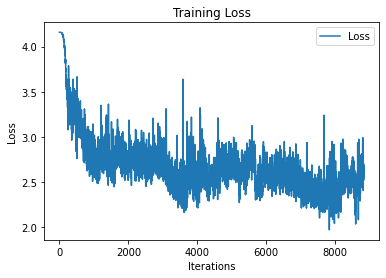

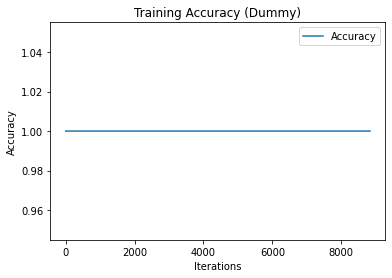

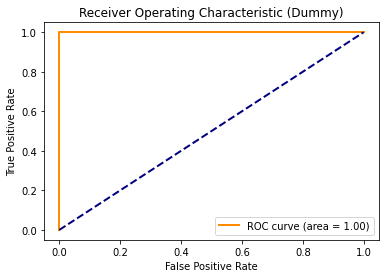

In [13]:
w2v.plot_metrics()

In [10]:
model = gensim.models.KeyedVectors.load_word2vec_format("model_skipgram.vec", binary=False)


In [11]:
words_to_test = ["juez", "ley", "decreto", "sentencia"]

In [12]:
test_model(model, words_to_test)


Palabras similares a 'juez':
  causa: 0.9255
  si: 0.9196
  juzgador: 0.9192
  pero: 0.9138
  puede: 0.9112

Palabras similares a 'ley':
  formalidades: 0.9686
  estatuto: 0.9656
  opongan: 0.9655
  fueren: 0.9654
  estricta: 0.9652

Palabras similares a 'decreto':
  objeción: 0.9812
  315: 0.9797
  95: 0.9797
  144: 0.9796
  73: 0.9792

Palabras similares a 'sentencia':
  auto: 0.9488
  juicio: 0.9423
  domicilio: 0.9416
  ha: 0.9413
  escrito: 0.9359
